# Q-Networks for Hexagon Chess

## Setup

In [1]:
# Setup
%matplotlib inline
%load_ext autoreload
%autoreload 2

In [2]:
# Import libraries
import numpy as np
import matplotlib.pyplot as plt
import os
import tensorflow as tf
import tensorflow.keras as krs
plt.style.use("tableau-colorblind10")
plt.rcParams.update({'font.size': 14})
print(tf.config.list_physical_devices('GPU'))

2024-04-04 10:58:36.690859: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-04-04 10:58:36.857296: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2024-04-04 10:58:36.857318: I tensorflow/compiler/xla/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
2024-04-04 10:58:37.494901: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory
2024-

[]


2024-04-04 10:58:38.740615: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2024-04-04 10:58:38.740641: W tensorflow/compiler/xla/stream_executor/cuda/cuda_driver.cc:265] failed call to cuInit: UNKNOWN ERROR (303)
2024-04-04 10:58:38.740658: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (pop-os): /proc/driver/nvidia/version does not exist


In [16]:
# Hex Chess Environment & Players
from hexchess.board import HexChessBoard
from engines.environment import HexChessEnv
from engines.qnetworks import QNetworkAgent, QLearning
from hexchess.players import RandomPlayer, GreedyPlayer
from utils import plot_step_rewards, plot_episode_rewards

In [17]:
# Constants
base_path = os.path.join("assets", "qnetworks")
figs_path = os.path.join("figures", "qnetworks")

## The environment

In [5]:
# Teach Q networks to play against a random agent playing white
opponent_class = RandomPlayer
opponent_is_white = True
apply_negative_scores = False
board_kwargs = {
    "initialize_random": True,
    "save_dir": os.path.join("states", )
}
env = HexChessEnv(opponent_class, opponent_is_white, apply_negative_scores=apply_negative_scores, board_kwargs=board_kwargs)

In [6]:
env.render()

     B K N R P * 
    Q B * * P * * 
   N * B * P * * * 
  R * * * P * * * * 
 P P P P P * * * * * 
* * * * * * * * * * * 
 * * * * * P P P P P 
  * * * * P * * * R 
   * * * P * B * N 
    * * P * * B K 
     * P R N Q B 


## The Agent

In [7]:
# Configure agent
is_large = True
use_pretrained_weights = False
pretrained_model_path = "./assets/qnetworks/random_pr_model_black.keras" if use_pretrained_weights else None

In [8]:
# Construct model name
pretrained_pre_ = os.path.splitext(os.path.basename(pretrained_model_path))[0].split("_")[0] if pretrained_model_path is not None else ""
opponent_name = opponent_class.name.split(" ")[0].lower()
_reward_app = "_nr" if apply_negative_scores else "_pr"
model_color = "black" if opponent_is_white else "white"
_large_app = "_large" if is_large else ""
model_name = f"{pretrained_pre_}{opponent_name}{_reward_app}_{model_color}{_large_app}"
print(model_name)

random_pr_black_large


In [9]:
# Initialize 
agent = QNetworkAgent(model_path=pretrained_model_path, is_large=is_large, discount_factor=0.25, learning_rate=1e-3)

2024-04-04 10:58:57.312378: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [10]:
agent.fix_model()
agent.model_fixed.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_skip_block_3 (Conv2D  (None, 11, 11, 6)        990       
 SkipBlock)                                                      
                                                                 
 up_sampling2d (UpSampling2D  (None, 33, 33, 6)        0         
 )                                                               
                                                                 
 conv2d_skip_block_4 (Conv2D  (None, 33, 33, 6)        990       
 SkipBlock)                                                      
                                                                 
 up_sampling2d_1 (UpSampling  (None, 99, 99, 6)        0         
 2D)                                                             
                                                                 
 conv2d_6 (Conv2D)           (None, 95, 95, 6)         9

## Learn

In [11]:
# Learning configuration
n_episodes = 1
model_fix_episodes = 10
max_episode_length = 10
batch_size = 512
memory_size = batch_size * 4

In [12]:
q_learning = QLearning(agent, env, memory_size=memory_size)

In [13]:
episode_rewards, step_rewards = q_learning.learn(
    n_episodes=n_episodes,
    model_fix_episodes=model_fix_episodes,
    max_episode_length=max_episode_length,
    batch_size=batch_size,
)

### Save results

In [14]:
# Save results
agent.model.save(os.path.join("assets", "qnetworks", f"{model_name}.keras"))
np.savetxt(os.path.join(base_path, f"{model_name}_episode_rewards.csv"), episode_rewards, delimiter=",")
np.savetxt(os.path.join(base_path, f"{model_name}_step_rewards.csv"), episode_rewards, delimiter=",")

### Load Results

In [12]:
# Model configuration
opponent_class = RandomPlayer
opponent_is_white = True
apply_negative_scores = False
is_large = False
use_pretrained_weights = False
pretrained_model_path = "./assets/qnetworks/random_pr_model_black.keras" if use_pretrained_weights else None

# Model name
pretrained_pre_ = os.path.splitext(os.path.basename(pretrained_model_path))[0].split("_")[0] if pretrained_model_path is not None else ""
opponent_name = opponent_class.name.split(" ")[0].lower()
_reward_app = "_nr" if apply_negative_scores else "_pr"
model_color = "black" if opponent_is_white else "white"
_large_app = "_large" if is_large else ""
model_name = f"{pretrained_pre_}{opponent_name}{_reward_app}_{model_color}{_large_app}"
print(model_name)

random_pr_black


In [13]:
# Load results
episode_rewards = np.loadtxt(os.path.join(base_path, f"{model_name}_episode_rewards.csv"), delimiter=",")
step_rewards = np.loadtxt(os.path.join(base_path, f"{model_name}_step_rewards.csv"))

### Visualize Results

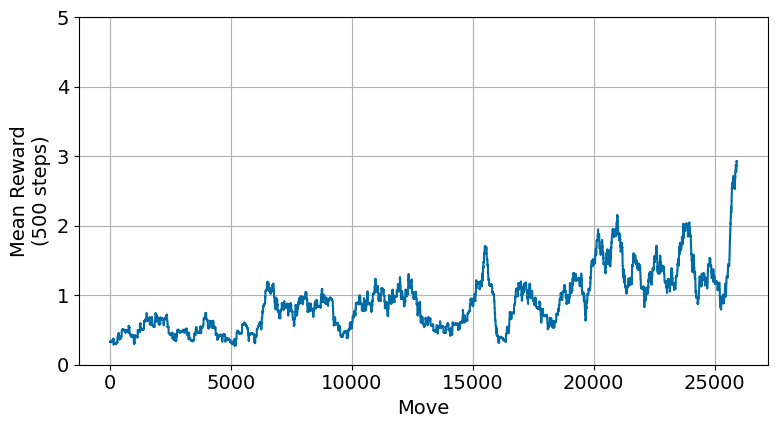

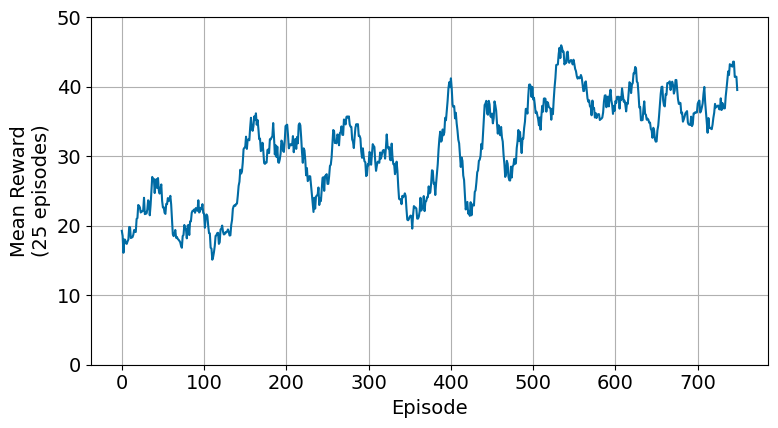

In [57]:
# Make plots
fig, ax = plot_step_rewards(step_rewards, save_path=os.path.join(figs_path, f"{model_name}_step_rewards.png"))
fig, ax = plot_episode_rewards(episode_rewards, save_path=os.path.join(figs_path, f"{model_name}_episode_rewards.png"))
plt.show()

In [64]:
# Generate all figures
model_names = [os.path.splitext(file)[0] for file in os.listdir(base_path) if os.path.splitext(file)[-1] == ".keras"]
for model_name in model_names:
    print(model_name)
    episode_rewards = np.loadtxt(os.path.join(base_path, f"{model_name}_episode_rewards.csv"), delimiter=",")
    step_rewards = np.loadtxt(os.path.join(base_path, f"{model_name}_step_rewards.csv"))
    fig, ax = plot_step_rewards(step_rewards, save_path=os.path.join(figs_path, f"{model_name}_step_rewards.png"))
    plt.close(fig)
    fig, ax = plot_episode_rewards(episode_rewards, save_path=os.path.join(figs_path, f"{model_name}_episode_rewards.png"))
    plt.close(fig)
    #plt.show()

random_pr_white
greedy_nr_black
greedy_pr_black
randomgreedy_pr_white
randomgreedy_pr_black
random_pr_black
random_nr_black
